In [30]:
import numpy as np
import pandas as pd
import pickle, csv
import os

from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, Dropout, Input, concatenate, Flatten, Reshape,MaxPooling2D, Conv2D, TimeDistributed, BatchNormalization
from keras import regularizers
from keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow.keras.backend as K
from skimage.transform import resize
from tensorflow.keras import layers, models


from matplotlib import pyplot as plt
from matplotlib import style
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

import datetime

import tensorflow.keras.backend as K
K.clear_session()

In [31]:
# Load powerprice data and format it
df_powerprice = pd.read_csv("data/PowerPrice.csv")
df_powerprice["Time"] = pd.to_datetime(df_powerprice["Time"], infer_datetime_format=True)
df_powerprice = df_powerprice.drop(columns=["Time"])
df_powerprice

,DayAhead,Spot,REBAP
0,2.83200,3.688,-4.566
1,2.37575,4.245,-13.964
2,1.91950,3.161,0.345
3,1.46325,1.664,3.048
4,1.00700,3.110,-6.679
...,...,...,...
35035,3.77625,3.342,4.856
35036,3.73900,4.425,8.561
35037,3.70175,2.473,6.076
35038,3.66450,3.241,11.797


In [32]:
# Load spatial data and format it
datasets = []
for filename in os.listdir("data/Spatial"):
    if filename.endswith(".pickle"):
        with open(os.path.join("data/Spatial", filename), "rb") as file:
            data = pickle.load(file)
            if data.shape == (100, 35040):
                datasets.append(data)
                print(filename)
            else:
                print(f"Skipping {filename}: unexpected shape {data.shape}")

biogas_kw_2019.pickle
brown_coal_kw_2019.pickle
completed_solar_kw_2019.pickle
completed_wind_onshore_kw_2019.pickle
demand_kw_2019.pickle
hard_coal_kw_2019.pickle
nuclear_kw_2019.pickle
oil_kw_2019.pickle
water_laufwasser_kw_2019.pickle
water_pumpspeicher_PB_kw_2019.pickle
water_pumpspeicher_TB_kw_2019.pickle
water_speicherwasser_kw_2019.pickle
wind_offshore_kw_2019.pickle


In [33]:
# Convert the list of arrays to a 3D array
spatial_data = np.stack(datasets, axis=0)

spatial_data = spatial_data.reshape((spatial_data.shape[0], spatial_data.shape[1], spatial_data.shape[2]))

# Transpose the second and third dimensions to get shape (13, 35040, 100)
spatial_data = spatial_data.transpose((0, 1, 2))

spatial_data.shape

(13, 100, 35040)

In [34]:
# Load mask and reshape to match desired output shape
mask = pd.read_csv("germany/mask.csv", header=None).values
#mask = mask_df.values.reshape((40, 40, 1))

mask.shape

(30, 30)

In [35]:
spatial_data.shape

(13, 100, 35040)

In [36]:
image_all = np.zeros((35040, 30, 30, 13))
for j in range(spatial_data.shape[2]):
    for i in range(spatial_data.shape[0]):
        image = np.zeros((30, 30))
        for s in range(spatial_data.shape[1]):
            image[mask == s] = spatial_data[i, s, j]
        image_all[j, :, :, i] = image

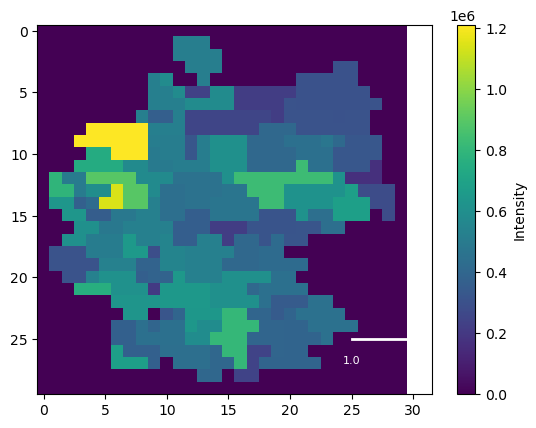

In [37]:
# Plot the specific image with the scale bar
plt.imshow(image_all[35030, :, :, 4])
plt.colorbar(label='Intensity')

scale_value = 1.0  # Specify the value for the scale bar
scale_bar_length = 5  # Specify the length of the scale bar in pixels

plt.plot([25, 25 + scale_bar_length], [25, 25], color='white', linewidth=2)
plt.text(25, 27, f'{scale_value}', color='white', ha='center', fontsize=8)

plt.show()

In [38]:
image_all.shape

(35040, 30, 30, 13)

In [39]:
#input_2 = df_powerprice["DayAhead"].values.reshape((-1, 4))
#input_2.shape

In [40]:
output = df_powerprice["Spot"].values

scaler = MinMaxScaler()
output = scaler.fit_transform(output.reshape(-1, 1))

output

array([[0.34239157],
       [0.34917003],
       [0.33597819],
       ...,
       [0.32760551],
       [0.33695176],
       [0.33731685]])

In [41]:
def split_datasets(df, df2, window_size, look_ahead):
    X = []
    y = []
    for i in range(len(df) - window_size - look_ahead + 1):
        row = df[i:i+window_size, :, :, :]
        X.append(row)
        label = df2[i+window_size+look_ahead-1]
        y.append(label)
    return np.array(X), np.array(y)

In [42]:
window_size = 4
look_ahead = 1
X, y = split_datasets(image_all, output, window_size=window_size, look_ahead=look_ahead)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (35036, 4, 30, 30, 13), y shape: (35036, 1)


In [43]:
# Reshape the input array to a 2D array
input_2d = X.reshape(-1, X.shape[-1])

# Scale the array using MinMaxScaler
scaler = MinMaxScaler()
input_scaled = scaler.fit_transform(input_2d)

# Reshape the scaled array back to the original shape
X = input_scaled.reshape(X.shape)

print("Scaled X shape:", X.shape)

Scaled X shape: (35036, 4, 30, 30, 13)


In [44]:
# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=40)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (22422, 4, 30, 30, 13)
y_train shape: (22422, 1)
X_val shape: (5606, 4, 30, 30, 13)
y_val shape: (5606, 1)
X_test shape: (7008, 4, 30, 30, 13)
y_test shape: (7008, 1)


In [45]:
time_steps = 4
width = 30
height = 30
channel = 13

# Define the input layer
input_layer = Input(shape=(time_steps, width, height, channel))

# Define the convolutional layers
cnn1 = Conv2D(filters=16, kernel_size=(3, 3))
cnn2 = MaxPooling2D(pool_size=(2, 2))
cnn3 = Conv2D(filters=32, kernel_size=(3, 3))
cnn4 = MaxPooling2D(pool_size=(2, 2))

# Apply TimeDistributed to the convolutional layers
td_cnn1 = TimeDistributed(cnn1)(input_layer)
td_cnn2 = TimeDistributed(cnn2)(td_cnn1)
td_cnn3 = TimeDistributed(cnn3)(td_cnn2)
td_cnn4 = TimeDistributed(cnn4)(td_cnn3)

# Reshape the output of the convolutional layers
reshaped = Reshape((-1, 6*6*32))(td_cnn4)

# Apply TimeDistributed Dense layer
td_fcnn = TimeDistributed(Dense(10))(reshaped)
td_fcnn = BatchNormalization()(td_fcnn)
td_fcnn = LeakyReLU()(td_fcnn)
td_fcnn = Dropout(0.5)(td_fcnn)

# Apply LSTM layers
lstm_output = LSTM(32, return_sequences=True)(td_fcnn)
lstm_output = Dropout(0.5)(lstm_output)
lstm_output = LSTM(16, return_sequences=True)(lstm_output)
lstm_output = Dropout(0.5)(lstm_output)
lstm_output = LSTM(1, return_sequences=False)(lstm_output)

# Create the model
model = Model(inputs=input_layer, outputs=lstm_output)

# Print the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 30, 30, 13)]   0         
                                                                 
 time_distributed (TimeDistr  (None, 4, 28, 28, 16)    1888      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 4, 14, 14, 16)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 4, 12, 12, 32)    4640      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 4, 6, 6, 32)      0         
 tributed)                                                   

In [46]:
# Compile the model with an appropriate optimizer and loss function
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [47]:
# Define callbacks for early stopping and checkpoint saving
es = EarlyStopping(monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)

In [48]:
today = datetime.datetime.now().strftime("%Y-%m-%d--%H-%M")

In [49]:
cp = ModelCheckpoint(filepath=f"training/model-website/model-{today}.h5", 
                      save_best_only=True,
                      monitor='val_loss', 
                      mode='min', 
                      save_weights_only=False, 
                      verbose=1)

In [50]:
# Fit the model on the training data
history = model.fit(X_train, y_train, batch_size=20, epochs=1000, validation_data=(X_val, y_val), callbacks=[cp, es])

Epoch 1/1000
1120/1122 [============================>.] - ETA: 0s - loss: 0.0205 - root_mean_squared_error: 0.1430
Epoch 1: val_loss improved from inf to 0.00067, saving model to training/model-website\model-2023-09-04--00-54.h5
1122/1122 [==============================] - 17s 10ms/step - loss: 0.0204 - root_mean_squared_error: 0.1430 - val_loss: 6.7459e-04 - val_root_mean_squared_error: 0.0260
Epoch 2/1000
1121/1122 [============================>.] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0502
Epoch 2: val_loss did not improve from 0.00067
1122/1122 [==============================] - 9s 8ms/step - loss: 0.0025 - root_mean_squared_error: 0.0502 - val_loss: 7.0472e-04 - val_root_mean_squared_error: 0.0265
Epoch 3/1000
1118/1122 [============================>.] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0368
Epoch 3: val_loss did not improve from 0.00067
1122/1122 [==============================] - 9s 8ms/step - loss: 0.0014 - root_mean_squared_error: 0.0369 - val

Epoch 24/1000
1118/1122 [============================>.] - ETA: 0s - loss: 2.6860e-04 - root_mean_squared_error: 0.0164
Epoch 24: val_loss did not improve from 0.00025
1122/1122 [==============================] - 10s 9ms/step - loss: 2.6876e-04 - root_mean_squared_error: 0.0164 - val_loss: 4.8030e-04 - val_root_mean_squared_error: 0.0219
Epoch 25/1000
1119/1122 [============================>.] - ETA: 0s - loss: 2.6401e-04 - root_mean_squared_error: 0.0162
Epoch 25: val_loss did not improve from 0.00025
1122/1122 [==============================] - 10s 9ms/step - loss: 2.6380e-04 - root_mean_squared_error: 0.0162 - val_loss: 3.1627e-04 - val_root_mean_squared_error: 0.0178
Epoch 26/1000
1117/1122 [============================>.] - ETA: 0s - loss: 2.5289e-04 - root_mean_squared_error: 0.0159
Epoch 26: val_loss did not improve from 0.00025
1122/1122 [==============================] - 10s 9ms/step - loss: 2.5250e-04 - root_mean_squared_error: 0.0159 - val_loss: 2.5710e-04 - val_root_mean_sq

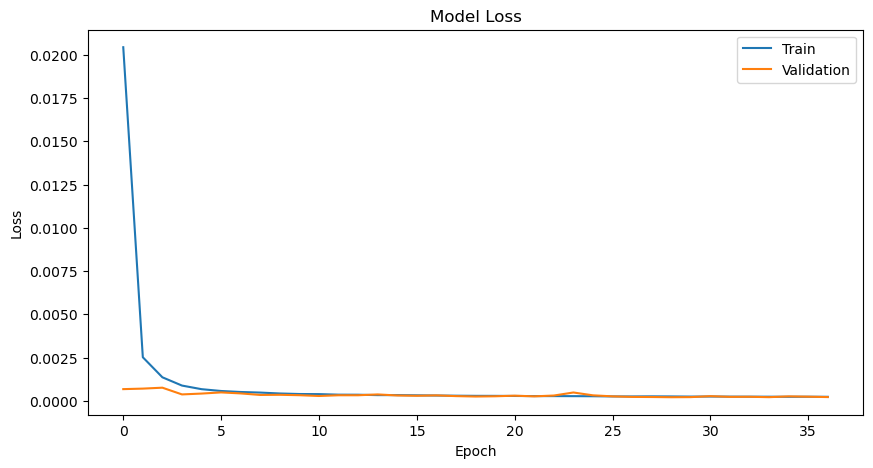

In [51]:
#Plot the training and validation loss

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

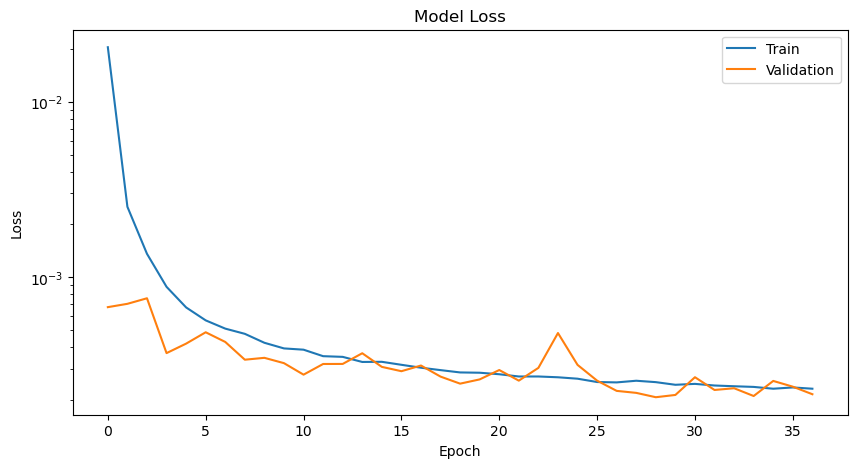

In [52]:
# Plot the training and validation loss on a logarithmic scale
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yscale('log')  # Set the y-axis scale to logarithmic
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


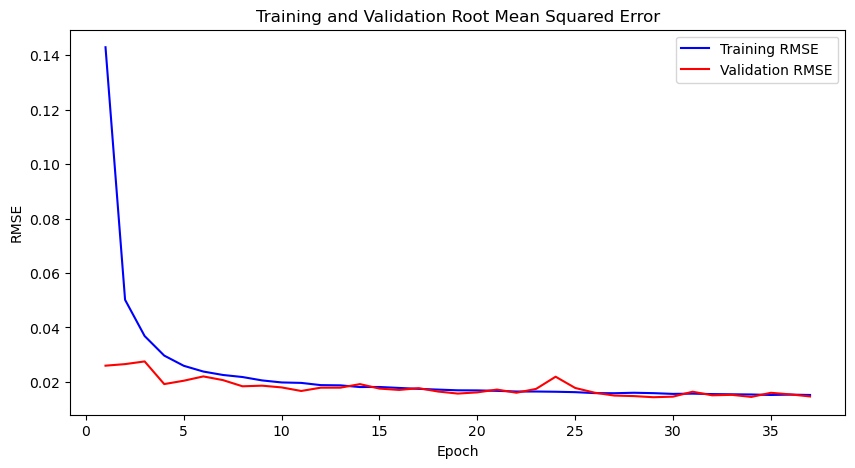

In [53]:
# Get the training and validation accuracy values from the history object
train_acc = history.history['root_mean_squared_error']
val_acc = history.history['val_root_mean_squared_error']

# Create a plot of training and validation accuracy
epochs = range(1, len(train_acc) + 1)
plt.figure(figsize=(10,5))
plt.plot(epochs, train_acc, 'b', label='Training RMSE')
plt.plot(epochs, val_acc, 'r', label='Validation RMSE')
plt.title('Training and Validation Root Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [54]:
# After training, print actual and predicted values for the validation data
y_val_pred = model.predict(X_val)
print("Actual\t\tPredicted")
for i in range(len(y_val)):
    print(f"{y_val[i]}\t{y_val_pred[i]}")

176/176 [==============================] - 1s 3ms/step
Actual		Predicted
[0.35826072]	[0.35892108]
[0.33700044]	[0.33842346]
[0.34828165]	[0.34857714]
[0.3806041]	[0.36566493]
[0.34185611]	[0.33888376]
[0.34488634]	[0.34536788]
[0.35778611]	[0.35877666]
[0.34236723]	[0.35592687]
[0.31877282]	[0.33201557]
[0.34117461]	[0.3365214]
[0.35967239]	[0.36881298]
[0.3405783]	[0.3483653]
[0.37370394]	[0.34815764]
[0.28674001]	[0.26629162]
[0.35987928]	[0.36006847]
[0.34024972]	[0.34359032]
[0.35592416]	[0.34426573]
[0.34049311]	[0.3465691]
[0.3556686]	[0.35853988]
[0.3423794]	[0.34912968]
[0.33338607]	[0.3433468]
[0.34599377]	[0.3598387]
[0.33463954]	[0.3373521]
[0.35761573]	[0.3608296]
[0.34979068]	[0.3481178]
[0.38589787]	[0.39218214]
[0.34882928]	[0.35317275]
[0.34912136]	[0.33737892]
[0.33959256]	[0.34083554]
[0.33815655]	[0.34009546]
[0.33850947]	[0.33756277]
[0.35312515]	[0.35173872]
[0.35289393]	[0.35241386]
[0.38519204]	[0.3921866]
[0.33051404]	[0.31903356]
[0.34691866]	[0.3520128]
[0.34

[0.33108601]	[0.33476734]
[0.33378766]	[0.32840326]
[0.30999611]	[0.31096837]
[0.36278781]	[0.39320683]
[0.33588084]	[0.34278998]
[0.35945334]	[0.36608455]
[0.31709098]	[0.33293647]
[0.34127197]	[0.33714798]
[0.34042009]	[0.3391998]
[0.32257947]	[0.31615642]
[0.35665433]	[0.34166718]
[0.29264226]	[0.27322352]
[0.30456847]	[0.3215062]
[0.30082023]	[0.33252883]
[0.35353892]	[0.36689517]
[0.34484983]	[0.32624772]
[0.33170666]	[0.33457762]
[0.34309741]	[0.35165074]
[0.34937692]	[0.34496006]
[0.35902741]	[0.37489328]
[0.36243489]	[0.36468938]
[0.33510198]	[0.34104475]
[0.36317724]	[0.38097557]
[0.36046342]	[0.3694194]
[0.34526359]	[0.3381443]
[0.32795843]	[0.33001184]
[0.37915592]	[0.3873147]
[0.34022538]	[0.34770218]
[0.34723507]	[0.35164237]
[0.3458599]	[0.34777904]
[0.35480456]	[0.3609548]
[0.33571046]	[0.34834078]
[0.31727352]	[0.32470697]
[0.34263496]	[0.34605554]
[0.37580928]	[0.3662498]
[0.34587207]	[0.34813648]
[0.36656039]	[0.35370487]
[0.38778416]	[0.38718665]
[0.34453342]	[0.3417

[0.3616317]	[0.35254064]
[0.36370053]	[0.3618244]
[0.367035]	[0.36899048]
[0.3725965]	[0.36087766]
[0.34263496]	[0.34590682]
[0.34568953]	[0.3485508]
[0.37129436]	[0.36523402]
[0.32804362]	[0.33591554]
[0.34601811]	[0.339349]
[0.34917003]	[0.34220257]
[0.31004478]	[0.31600213]
[0.34302439]	[0.34785262]
[0.33467605]	[0.34270853]
[0.38726087]	[0.3772579]
[0.35540087]	[0.35170612]
[0.32591394]	[0.31164855]
[0.32956482]	[0.3335018]
[0.29259358]	[0.3025367]
[0.35609453]	[0.35540387]
[0.35681254]	[0.3499252]
[0.33018546]	[0.34099862]
[0.34652923]	[0.33852568]
[0.35144575]	[0.35372007]
[0.34927956]	[0.34845892]
[0.33442048]	[0.33994362]
[0.32692401]	[0.3253549]
[0.35840676]	[0.35449383]
[0.33285061]	[0.33876294]
[0.40555177]	[0.3935633]
[0.3517865]	[0.3503821]
[0.33196223]	[0.3380446]
[0.34352334]	[0.34335968]
[0.33964124]	[0.33764982]
[0.34941343]	[0.34480846]
[0.27800224]	[0.2920101]
[0.34920654]	[0.3430777]
[0.34203865]	[0.34409922]
[0.35024096]	[0.34621736]
[0.36288517]	[0.36141425]
[0.33

In [55]:
y_val.shape

(5606, 1)

In [56]:
y_val_pred.shape

(5606, 1)

In [57]:
# Define the minimum and maximum values of the original data
min_price = df_powerprice["Spot"].min()
max_price = df_powerprice["Spot"].max()

# Inverse transform the scaled actual values (y_val)
y_val_original = (y_val * (max_price - min_price)) + min_price

# Inverse transform the scaled predicted values (y_val_pred)
y_val_pred_original = (y_val_pred * (max_price - min_price)) + min_price

# Print the original actual and predicted values
print("Actual\t\tPredicted")
for i in range(len(y_val_original)):
    actual = y_val_original[i]
    predicted = y_val_pred_original[i]
    print(f"{actual}\t{predicted}")

Actual		Predicted
[4.992]	[5.046261]
[3.245]	[3.3619308]
[4.172]	[4.1962795]
[6.828]	[5.600416]
[3.644]	[3.3997555]
[3.893]	[3.9325676]
[4.953]	[5.0343933]
[3.686]	[4.8002205]
[1.7472]	[2.8353825]
[3.588]	[3.2056332]
[5.108]	[5.8590984]
[3.539]	[4.178873]
[6.261]	[4.161808]
[-0.885]	[-2.5652866]
[5.125]	[5.140545]
[3.512]	[3.7865028]
[4.8]	[3.8420029]
[3.532]	[4.031273]
[4.779]	[5.0149384]
[3.687]	[4.241682]
[2.948]	[3.7664928]
[3.984]	[5.121664]
[3.051]	[3.2738953]
[4.939]	[5.203087]
[4.296]	[4.158535]
[7.263]	[7.7793903]
[4.217]	[4.5739098]
[4.241]	[3.2760983]
[3.458]	[3.5601368]
[3.34]	[3.499323]
[3.369]	[3.2912064]
[4.57]	[4.456072]
[4.551]	[4.511551]
[7.205]	[7.7797565]
[2.712]	[1.7686253]
[4.06]	[4.4785957]
[4.24]	[3.742422]
[3.256]	[3.9881096]
[3.788]	[4.7154446]
[3.844]	[3.5608196]
[4.43]	[3.822525]
[3.633]	[4.39167]
[-0.732]	[0.1712017]
[4.152]	[3.2419815]
[3.577]	[3.2325478]
[4.421]	[5.165806]
[4.124]	[4.559664]
[1.715]	[3.0287704]
[5.567]	[3.885563]
[3.673]	[3.9373531]
[3.07

[2.082]	[2.6420765]
[4.211]	[4.526119]
[5.03]	[5.5316105]
[3.774]	[3.312727]
[4.468]	[4.6469135]
[4.683]	[5.086426]
[4.622]	[4.9645367]
[2.648]	[3.3143902]
[6.616]	[5.253372]
[4.529]	[5.0848656]
[3.489]	[3.0230446]
[4.058]	[4.296665]
[3.737]	[4.100748]
[13.07]	[7.664858]
[2.769]	[1.2128925]
[3.442]	[2.9781914]
[3.583]	[3.4994278]
[3.319]	[3.9956284]
[5.274]	[4.312378]
[5.092]	[5.38163]
[3.591]	[3.54743]
[3.006]	[4.9760456]
[2.711]	[3.3266392]
[4.822]	[4.999172]
[4.881]	[5.8875427]
[3.494]	[2.74082]
[0.059]	[1.2221756]
[4.649]	[3.8287945]
[5.956]	[5.9024525]
[2.054]	[2.636629]
[3.639]	[4.1066837]
[0.163]	[0.6668415]
[3.608]	[4.0263195]
[6.02]	[4.4930363]
[2.636]	[3.6840096]
[5.35]	[4.651945]
[4.184]	[4.821705]
[5.613]	[7.0939064]
[3.328]	[3.4528217]
[4.306]	[3.7343616]
[4.977]	[5.1180515]
[2.132]	[3.7457123]
[4.69]	[4.654249]
[3.224]	[3.4264355]
[2.669]	[3.4968796]
[1.921]	[2.0749588]
[3.061]	[4.01021]
[3.226]	[3.0456486]
[5.967]	[5.3604527]
[5.714]	[4.589573]
[3.833]	[4.1876354]
[3.404

[1.428]	[1.07477]
[3.958]	[4.1386223]
[2.864]	[3.2201576]
[3.618]	[3.6380424]
[2.913]	[3.8046951]
[4.349]	[4.921442]
[4.208]	[4.1466618]
[5.148]	[5.5345535]
[4.658]	[4.5159073]
[5.032]	[5.880636]
[5.755]	[5.408003]
[4.716]	[4.0461044]
[3.455]	[3.5497723]
[3.885]	[4.2367764]
[6.764]	[5.936859]
[3.529]	[4.598835]
[2.493]	[2.6848392]
[2.475]	[1.0555191]
[-1.457]	[-2.4996357]
[3.75]	[3.3713474]
[3.686]	[3.6644478]
[2.271]	[3.8306637]
[4.668]	[3.3453598]
[4.886]	[4.1768837]
[3.252]	[3.8202286]
[3.184]	[4.0482845]
[4.443]	[4.906786]
[7.304]	[7.1459064]
[2.869]	[3.9666805]
[4.166]	[4.460882]
[3.725]	[4.1276093]
[5.177]	[5.152025]
[3.906]	[4.2757225]
[4.044]	[3.8850708]
[4.594]	[5.151716]
[3.324]	[4.8923645]
[3.392]	[4.10063]
[3.459]	[3.2995968]
[7.966]	[5.2634945]
[3.473]	[3.4866867]
[2.055]	[2.8492012]
[1.721]	[2.131483]
[3.007]	[2.3166866]
[3.074]	[3.376461]
[7.395]	[6.216263]
[3.088]	[3.5576305]
[3.804]	[3.5213203]
[2.42]	[3.7752323]
[3.46]	[3.6217613]
[3.783]	[3.1989117]
[6.19]	[5.219368]

[4.288]	[4.4828434]
[3.599]	[3.6724014]
[2.949]	[3.5832272]
[4.847]	[5.9773293]
[3.506]	[3.658432]
[8.567]	[8.758562]
[5.224]	[4.4685345]
[4.147]	[4.4864826]
[3.511]	[3.8051891]
[0.793]	[2.8175125]
[9.09]	[10.233713]
[5.053]	[3.546772]
[3.994]	[3.7928085]
[4.937]	[4.799431]
[4.847]	[4.821192]
[3.263]	[3.8364143]
[4.292]	[4.717457]
[4.74]	[4.746008]
[3.214]	[3.1446514]
[2.18]	[3.0973377]
[0.748]	[2.7342243]
[2.244]	[2.2253819]
[4.829]	[4.541376]
[4.71]	[5.0528984]
[3.094]	[4.107744]
[3.948]	[3.597166]
[3.717]	[3.1037445]
[4.169]	[4.2696667]
[4.095]	[5.772356]
[4.737]	[5.005392]
[5.858]	[6.0065994]
[2.932]	[2.2051048]
[4.894]	[4.562622]
[4.923]	[5.249941]
[4.996]	[4.984373]
[4.065]	[4.492302]
[3.15]	[4.190502]
[2.477]	[3.0326958]
[6.319]	[5.55904]
[3.309]	[3.570881]
[3.493]	[3.81118]
[4.608]	[4.306814]
[5.476]	[4.7575912]
[6.261]	[5.677948]
[1.108]	[2.2411976]
[4.267]	[4.7492027]
[3.444]	[3.521902]
[4.066]	[4.4416485]
[4.031]	[3.586546]
[0.347]	[-2.6152935]
[4.062]	[3.906767]
[4.243]	[3.

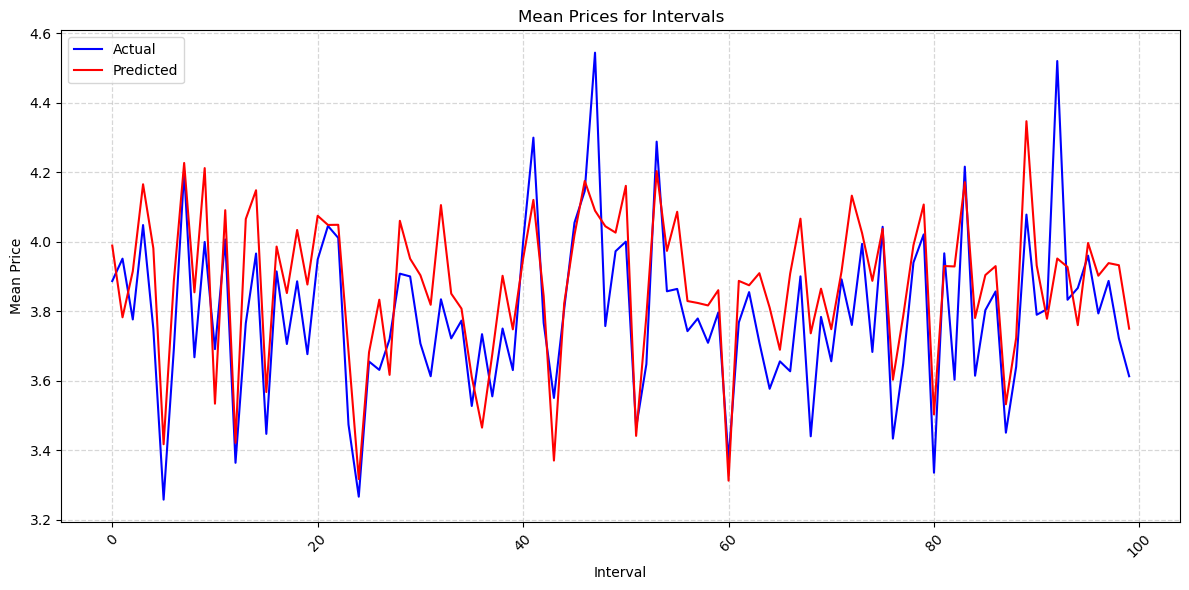

In [58]:
# Define the number of intervals
num_intervals = 100

# Calculate the interval size
interval_size = len(y_val_original) // num_intervals

# Calculate the means for each interval
interval_means_actual = [np.mean(y_val_original[i * interval_size:(i + 1) * interval_size]) for i in range(num_intervals)]
interval_means_pred = [np.mean(y_val_pred_original[i * interval_size:(i + 1) * interval_size]) for i in range(num_intervals)]

# Generate x-axis values for the intervals
x_values = np.arange(num_intervals)

# Plotting the interval means
plt.figure(figsize=(12, 6))
plt.plot(x_values, interval_means_actual, label='Actual', color='blue')
plt.plot(x_values, interval_means_pred, label='Predicted', color='red')
plt.xlabel('Interval')
plt.ylabel('Mean Price')
plt.title('Mean Prices for Intervals')
plt.legend()

# Customize the appearance of the plot
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', linewidth=0.9, alpha=0.5)

plt.tight_layout()
plt.show()